# Tutorial on neuronal package

**names: Amelia Paine, Han Sae Jung**

## Motivation

Commonly, electrophysiological data is processed by a bandpass filter and a moving average. Afterwards, neuronal signals are detected by thresholding or template-based methods. Then, the peak amplitudes of the identified spikes are quantified by simply subtracting the peak of the signal from the baseline. While these methods are computationally effective and have become a standard protocol for analyzing electrophysiological data, they render phase distortions to the signals to a certain extent; hence, we lose some information about the signals along the way.

Our goal is to analyze these data in a more statistically rigorous manner. Starting with the generative model proposed by Merel et al. ($\textit{J. Neurosci Methods}$ **2016**), we will first infer the spike timings and peak amplitudes of postsynaptic potentials (PSP) in a Bayesian manner. Afterwards, we will modify the model in a way that accounts for action potentials (AP) as well. Additionally, we will work on resolving complications that arise from real electrophysiological data (e.g. varying baseline).

## Generative Model from Merel et al. ($\textit{J. Neurosci Methods}$ **2016**)

Our model is adpated from the model suggested by Merel et al. ($\textit{J. Neurosci Methods}$ **2016**)

Their generative model is the following:

$$y_t = \sum_{i=1}^{n} a_i f_i(t - t_i) + b + \epsilon_t$$

$$f_i(t) = (\exp(-t / \tau_i^d) - \exp(-t / \tau_i^r)) \: \text{for} \: t \ge 0$$ 

$$\epsilon_t = \sum_{j=1}^{p} \phi_j \epsilon_{t-j} + u_t , \: u_t \approx N(0, \sigma^2)$$ 

$\text{where}$ 

$y_t \equiv \text{observed voltage trace}$, 

$t_i \equiv \text{spike time of} \: i^{th} \: \text{PSP}$, 

$n \equiv \text{number of PSP's}$, 

$b \equiv \text{constant baseline}$, 

$f_i(t) \equiv \text{mathematical trial function of PSP}$, 

$\epsilon_t \equiv \text{general AR(p) autoregressive model of the noise}$, 

$u_t \equiv \text{Gaussian noise}$, 

$\tau_i^d \equiv \text{decay time constant}$, 

$\tau_i^r \equiv \text{rise time constant}$, 

$a_i \equiv \text{constant related to the peak amplitude of each PSP}$


# Our Generative Model for PSP's

The generative model described above assumes a constant baseline. However, there is usually a varying baseline. Because the baseline tends to vary non-periodically, even if there were a mathematical function that can be used to model the baseline, it's likely to be incredibly complicated. Instead, we will account for the varying baseline by piecewise, linearly varying segments (in the form $mx + b$). Also, instead of considering a general AR(p) noise process, we will focus on AR(0) process (i.e. Gaussian i.i.d. noise).

$$y_t = H(t_1 - t) \cdot (b_{start} + \frac{b_1 - b_{start}}{t_1 - t_{start}} \cdot (t - t_{start})) + \sum_{i=1}^{n-1} H(t - t_i) \cdot H(t_{i+1} - t) \cdot (a_i f_i(t - t_i) + \frac{b_{i+1} - b_{i}}{t_{i+1} - t_i} \cdot (t - t_i))$$
$$+ \: H(t - t_{n}) \cdot H(t_{end} - t) \cdot (b_{n} + \frac{b_{end} - b_n}{t - t_{n}}) + \epsilon_t$$

$$\text{where}$$

$$H(x) \equiv \text{Heaviside step function} \: (\text{aka} \: H(x \ge 0) = 1 \: \text{and} \: H(x < 0) = 0)$$

$$f_i(t) = (\exp(-t / \tau_i^d) - \exp(-t / \tau_i^r)) \: \text{for} \: t \ge 0$$ 

$$\text{and} \: \epsilon_t = u_t , u_t \approx N(0, \sigma^2)$$ 

$\text{where}$ 

$y_t \equiv \text{observed voltage trace}$,

$t_{start} \equiv \text{start time of the data}$,

$t_{end} \equiv \text{end time of the data}$

$t_i \equiv \text{spike time of} \: i^{th} \: \text{PSP}$, 

$n \equiv \text{number of PSP's}$, 

$b_{start} \equiv \text{constant baseline before the first PSP spike}$,

$b_i \equiv \text{constant baseline starting from} \: i^{th} \: \text{PSP spike upto} \: {i+1}^{th} \: \text{PSP spike}$, 

$b_{end} \equiv \text{constant baseline at} \: t_{end}$,

$f_i(t) \equiv \text{mathematical trial function of PSP}$, 

$u_t \equiv \text{Gaussian noise}$, 

$\tau_i^d \equiv \text{decay time constant}$, 

$\tau_i^r \equiv \text{rise time constant}$, 

$a_i \equiv \text{constant related to the peak amplitude of each PSP}$

By differentiating $f_i(t)$ with respect to $t$, we find that the maximum of the signal occurs at $t_i = t_i^*$:

$$t_i^* = \frac{ln(\tau_i^d / \tau_i^r)}{1 / \tau_i^r - 1 / \tau_i^d}$$

Then, 

$$a_i^{peak} = a_i \cdot f_i(t=t^*)$$

For AR(0) case (Gaussian i.i.d. noise), our likelihood function is:

$$ p(Y|\Theta) = \prod_{t=1}^{T} \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(y_t-\hat{y_t})^2}{2\sigma^2}\right)$$

where $\hat{y_t}$ refers to the predicted noiseless trace:

$$\hat{y_t} = H(t_1 - t) \cdot (b_{start} + \frac{b_1 - b_{start}}{t_1 - t_{start}} \cdot (t - t_{start})) + \sum_{i=1}^{n-1} H(t - t_i) \cdot H(t_{i+1} - t) \cdot (a_i f_i(t - t_i) + \frac{b_{i+1} - b_{i}}{t_{i+1} - t_i} \cdot (t - t_i))$$
$$+ \: H(t - t_{n}) \cdot H(t_{end} - t) \cdot (b_{n} + \frac{b_{end} - b_n}{t - t_{n}})$$

In order for our model to be successful, we need to somehow account for the following noise sources:

**examples of noise sources: electrical hardware, analog to digital conversion, membrane oscillations and local field potential from other neurons (not immediately adjacent to the electrode from which we are measuring), solution in which neurons are cultured, changes in resistance between the electrode and the interior of the neuron**

Since our noise is a mixture of a wide range of sources, we can argue that Gaussian i.i.d. noise model is valid (on the basis of central limit theorem) to a certain extent.

Since we are assuming AR(0) case (Gaussian i.i.d. noise), our likelihood function is:

$$ p(Y|\Theta) = \prod_{t=1}^{T} \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(y_t-\hat{y_t})^2}{2\sigma^2}\right)$$

where $\hat{y_t}$ refers to the predicted noiseless trace:

$$\hat{y_t} = \sum_{i=1}^{n} a_i f_i(t - t_i) + b$$

Given this model, the log likelihood function is:

$$L(\Theta|Y) \propto ln p(Y|\Theta) \: + \: ln p(\Theta)$$

In [5]:
#Standard imports
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm

## Importing Data

Let's import the data using a NeuronalData object. This stores the imported data in a pandas DataFrame under columns T (time) and V (voltage signal).

The user may specify any file path pointing to correctly-formatted data, but in this case we will use the example data provided with the package. num_psp, the number of PSPs in the data, should also be specified at import.

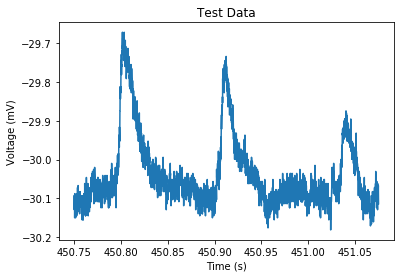

In [6]:
#our package import
import neuronal

three_psp = neuronal.NeuronalData(neuronal.get_example_data_file_path('three_PSP_data.txt'), num_psp=3)

#Plot the data to guess the parameters
plt.plot(three_psp.data['T'], three_psp.data['V'])
plt.title('Test Data')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

## Parameter estimation

psp_fit performs Hamiltonian MC parameter estimation using a NUTS sampler. This converges best when a reasonable initial guess is supplied.

| Parameter | Description |
|------|------|
| sigma | width of Gaussian noise |
| b_start | constant baseline before the first PSP spike |
| b | list of constant baselines after each PSP spike |
| b_end | constant baseline after the last PSP spike |
| a | list of constants related to peak amplitudes for each PSP |
| t_psp | list of start times for each PSP |
| tau_d | list of decay time constants for each PSP |
| tau_r | list of rise time constants for each PSP |

In [7]:
#The function behind the scenes
neuronal.psp_fit??

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '14628' (I am process '12312')
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau_r, tau_d, t_psp, a, sigma, b_end, b, b_start]
Sampling 2 chains: 100%|██████████| 3000/3000 [19:32<00:00,  1.20draws/s]
There were 155 divergences after tuning. Increase `target_accept` or reparameterize.
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


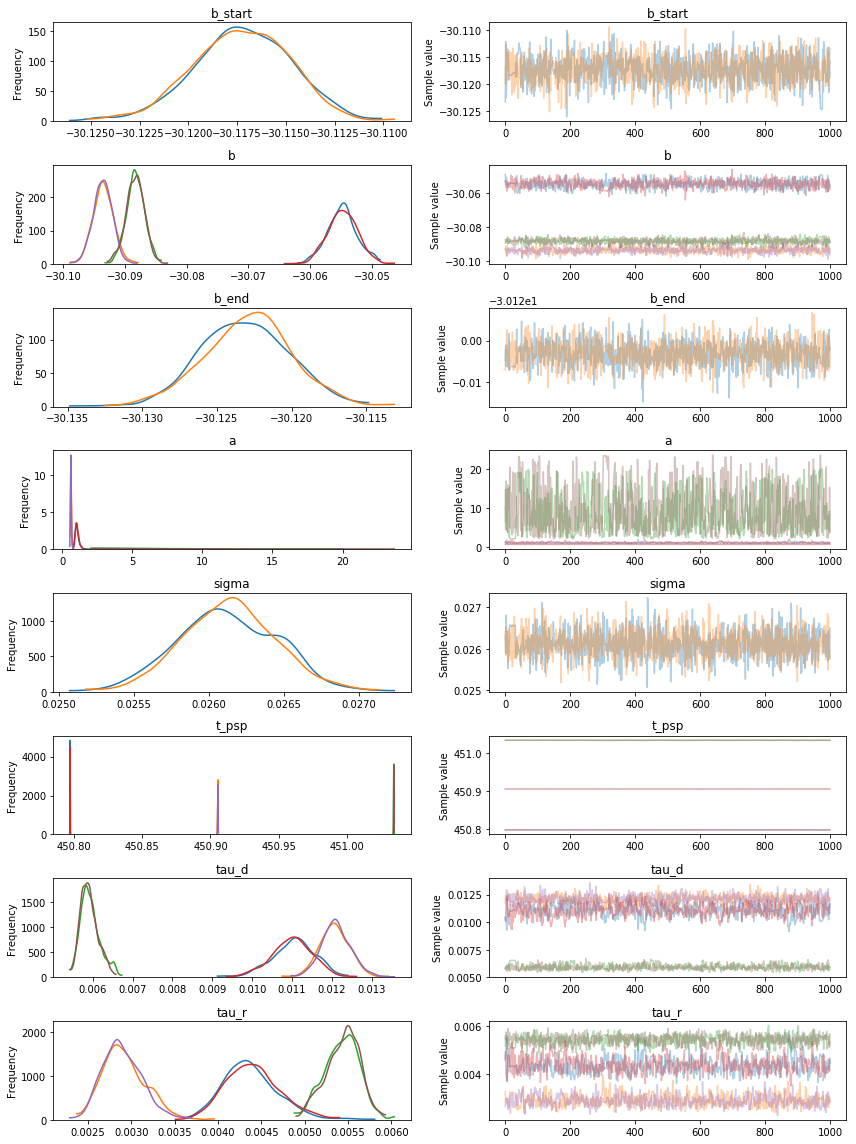

In [4]:
#Perform parameter estimation

initial_guess = {'sigma': 0.026, 'b_start': -30.1, 'b': [-30.05, -30.1, -30.1], 'b_end': -30.1,
                 'a': [0.8, 0.6, 14.86], 't_psp': [450.78, 450.90, 451.03], 'tau_d': [0.01, 0.01, 0.005217], 
                 'tau_r': [0.001, 0.001, 0.005038]
                }

sample3 = neuronal.psp_fit(three_psp, 1000, initial_guess)

In [5]:
summary3 = pm.summary(sample3)
summary3

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b_start,-30.117286,0.002471,0.000070,-30.121617,-30.112095,1201.542327,0.999844
b__0,-30.054792,0.002369,0.000083,-30.059083,-30.049719,722.118382,0.999942
b__1,-30.093613,0.001591,0.000049,-30.096851,-30.090685,850.782825,1.000234
b__2,-30.088355,0.001464,0.000046,-30.091203,-30.085373,927.849145,0.999930
b_end,-30.123061,0.002944,0.000086,-30.129015,-30.117455,1117.940469,1.001423
a__0,1.067515,0.137619,0.006506,0.853692,1.346253,390.260742,1.000535
a__1,0.630062,0.036539,0.001405,0.561120,0.701012,570.877941,1.003576
a__2,9.015241,5.648184,0.247822,2.023642,20.030507,477.615302,1.008657
sigma,0.026129,0.000324,0.000008,0.025484,0.026734,1747.130978,1.000035
t_psp__0,450.797134,0.000081,0.000003,450.796978,450.797293,660.619164,0.999915


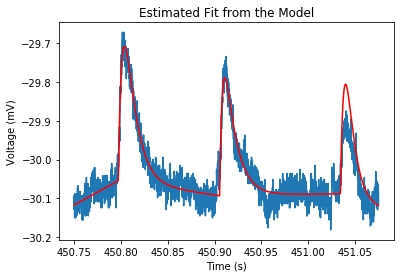

In [6]:
neuronal.plot_fit(three_psp, summary3)

Now, let's apply our new generative model to two PSP's on a linearly varying baseline.

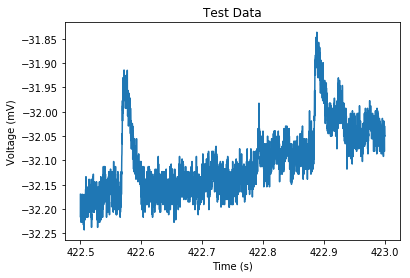

In [8]:
two_psp = neuronal.NeuronalData(neuronal.get_example_data_file_path('two_PSP_data.txt'), num_psp=2)

#Plot the data to guess the parameters
plt.plot(two_psp.data['T'], two_psp.data['V'])
plt.title('Test Data')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau_r, tau_d, t_psp, a, sigma, b_end, b, b_start]
Sampling 2 chains: 100%|██████████| 3000/3000 [09:59<00:00,  2.28draws/s]
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


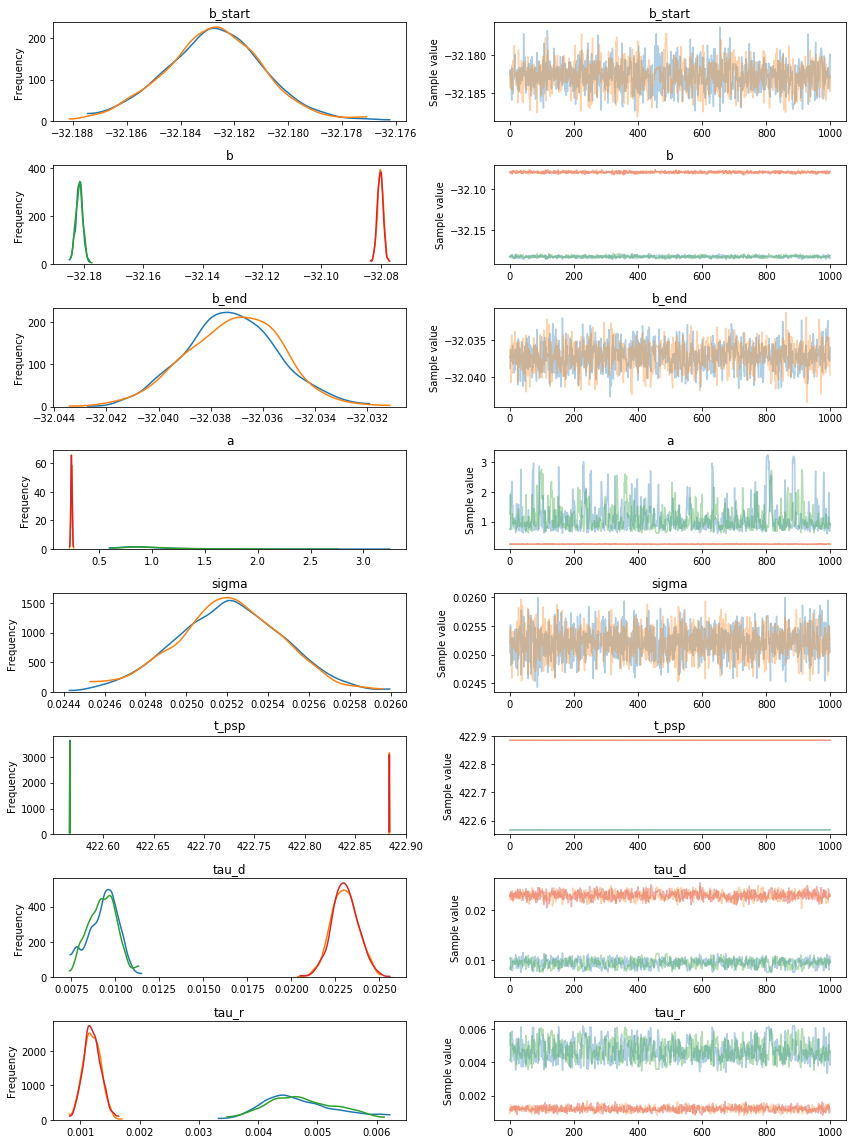

In [8]:
#Perform parameter estimation

initial_guess = {'sigma': 0.026, 'b_start': -32.19, 'b': [-32.17, -32.07], 'b_end': -32.05,
                 'a': [0.35, 0.3], 't_psp': [422.57, 422.885], 'tau_d': [0.01, 0.01], 'tau_r': [0.001, 0.001]
                }

sample2 = neuronal.psp_fit(two_psp, 1000, initial_guess)

In [9]:
summary2 = pm.summary(sample2)
summary2

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b_start,-32.182762,0.001828,0.000046,-32.186463,-32.179226,1406.084534,0.999804
b__0,-32.181540,0.001187,0.000034,-32.183852,-32.179228,1066.999633,0.999764
b__1,-32.080191,0.001015,0.000028,-32.082306,-32.078300,1225.554266,1.001787
b_end,-32.037180,0.001772,0.000053,-32.040636,-32.033713,1120.825832,1.000130
a__0,1.120766,0.470311,0.023345,0.598249,2.148397,378.498993,0.999669
a__1,0.241795,0.006099,0.000213,0.230294,0.254251,866.599505,0.999625
sigma,0.025206,0.000259,0.000005,0.024656,0.025677,1919.936893,0.999618
t_psp__0,422.566911,0.000103,0.000003,422.566706,422.567103,1063.892080,1.000993
t_psp__1,422.883941,0.000123,0.000003,422.883702,422.884166,1188.194066,0.999750
tau_d__0,0.009305,0.000816,0.000034,0.007550,0.010607,482.403324,1.000689


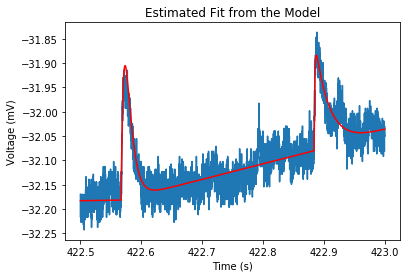

In [10]:
neuronal.plot_fit(two_psp, summary2)